<b>Dans ce notebook on nettoie le dataset sur la base des éléments décrits par le notebook Describe_Dataset</b>

# Table of contents
1. [Load du dataset](#load)
2. [Mise à l'écart des données US](#purge_us)
3. [Mise à l'écart des features redondantes](#purge_redund)
4. [Mise à l'écart des features 100% NaN](#purge_nan)
5. [Regroupement des PNNS](#pnns)
6. [Traitement des outliers](#outliers) 
7. [Imputations](#imputations)

    7.1 [High density features](#impute_high_density)
    
    7.2 [Mid density features](#impute_mid_density)
   


<b  style="background-color:tomato;font-size:14px;">1. LOAD DU DATASET<b>
    <a id="load"></a>   

In [140]:
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

try:
    del data
except:
    dummy=1

#On ne prend qu'un échantillon du fait des limitations mémoire de la machine
data=pd.read_csv('../dataset/en.openfoodfacts.org.products.csv',sep='\t',nrows=300000)

/home/alpro/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,12,18,19,20,21,22,26,27,28,30,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<b  style="background-color:tomato;font-size:14px;">2. MISE A L'ECART DES DONNEES US<b>
    <a id="load"></a>  

In [ ]:
us_to_remove = data[data['countries_tags']=="en:united-states"]
#us_to_remove = data['countries_tags']
len(us_to_remove)

<b  style="background-color:tomato;font-size:14px;">3. MISE A L'ECART DES FEATURES REDONDANTES<b>
    <a id="load"></a>  

In [ ]:
columns_to_remove = []
for s in data.columns:
    if "_tags" in s: 
        t = s.replace('_tags', '')
        u = s.replace('_tags', '_en')
        print("{:<20} 'no suffix' -> {} ; '_en' suffix -> {}".format(s,t in data.columns, u in data.columns))
        if t in data.columns: columns_to_remove.append(t)
        if u in data.columns: columns_to_remove.append(u)
data.drop(columns_to_remove, axis = 1, inplace = True)

<b  style="background-color:tomato;font-size:14px;">4. MISE A L'ECART DES FEATURES 100% NaN<b>
    <a id="load"></a>  

In [141]:
percent_of_nans = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100

In [ ]:
useless_features = percent_of_nans[percent_of_nans == 100].index
print(useless_features)
data.drop(useless_features, axis=1, inplace=True)
data.shape

<b  style="background-color:tomato;font-size:14px;">5. REGROUPEMENT DES PNNS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:14px;">6. TRAITEMENT DES OUTLIERS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:14px;">7. IMPUTATIONS<b>
    <a id="load"></a>  

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.1. HIGH DENSITY FEATURES<b>
    <a id="load"></a>  

In [142]:
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None
import math

def knn_imputation(df_knn,nn):
    
    imputer = KNNImputer(n_neighbors=nn, weights='uniform', metric='nan_euclidean')
    
    #print(df_knn)
    
    df_filled = imputer.fit_transform(df_knn)
    #print(type(df_filled))
    #print('---------------------')
    #print(df_filled[:,1])
    #print('---------------------')
    return df_filled[:,1]

def mean_imputation(df,feature):
    #print('mean imputation')
    #print('feature = ' + feature)
    #print(df.head())
    df_feature_mean = df[feature].mean()
    df.loc[(df[feature].isnull()),feature]=df_feature_mean

    #print('---------------------')
    #print(df[feature])
    #print('---------------------')
    
    return df[feature]

def imputation(data,features,type):
    mean_updates=pd.DataFrame()
    mean_dict={"feature":[],"original_mean":[],"original_std":[],"new_mean":[],"new_std":[]}
    
    cpt_feature=0
    for feature in features.index:
        #print('******* ' + feature)    
        subset = data[['categories_tags',feature]]

        #valuate mean and standard deviation before knn algorithm
        feature_mean = subset[feature].mean()
        feature_std = subset[feature].std()
        feature_mean_new = feature_mean
        feature_std_new = feature_std
        #print('    - mean = ' + str(feature_mean))
        #print('    - std = ' + str(feature_std))

        subset = subset[subset["categories_tags"].notna()]
        #print(subset.head())

        i=[]
        for k in range(subset.shape[0]):
            i.append(0)
        #add dummy column as knn only works at least 2 numerical columns subsets     
        subset['dummy']=i
        cpt_categ=0
        for col in subset['categories_tags'].unique():
            #print('* ' + col)
            subset_cat=subset.loc[data['categories_tags'] == col]
            #print(str(len(subset_cat)))
            #print(subset_cat)

            #We don't try imputation if category does not have a single valuated row or if category does not have any nan
            feature_categ_mean = subset_cat[feature].mean()
            if (not math.isnan(feature_categ_mean)) and subset_cat[feature].isnull().values.any():
                subset_imputation=subset_cat[['dummy',feature]]
                if type == "knn":
                    new_values = knn_imputation(subset_imputation,3)
                if type == "mean":
                    new_values = mean_imputation(subset_imputation,feature)
                subset_cat['newvalues']=new_values
                #print(subset_cat)

                #Identify row index where values has been changed. Update with imputed value in the dataframe.
                #print('changed indexes')
                #print('---------------')
                changed_values=subset_cat.loc[(subset_cat[feature] != subset_cat['newvalues'])]
                #print(changed_values)
                for d in changed_values.index:
                    print('**** '+ str(d) + ' ---> ' + str(changed_values.at[d,'newvalues']))
                    data.at[d, feature] = changed_values.at[d,'newvalues']
            cpt_categ = cpt_categ +1
            if cpt_categ == 15:
                break
            
        subset = data[['categories_tags',feature]]
        feature_mean_new = subset[feature].mean()
        feature_std_new = subset[feature].std()
        #print('    - mean = ' + str(feature_mean_new))
        #print('    - std = ' + str(feature_std_new))

        mean_dict["feature"].append(feature)
        mean_dict["original_mean"].append(feature_mean)
        mean_dict["original_std"].append(feature_std)
        mean_dict["new_mean"].append(feature_mean_new)
        mean_dict["new_std"].append(feature_std_new)
        
        cpt_feature = cpt_feature +1
        if cpt_feature == 3:
            break            


    mean_updates=pd.DataFrame.from_dict(mean_dict)
    print(mean_updates)

    plt.figure(figsize=(20,5))

    sns.lineplot(data=mean_updates, x="feature", y="original_mean",color="blue", label="Moyenne originale")
    sns.lineplot(data=mean_updates, x="feature", y="new_mean",color="green", label="Moyenne après imputation")
    sns.lineplot(data=mean_updates, x="feature", y="original_std",color="orange", label="Ecart type original")
    sns.lineplot(data=mean_updates, x="feature", y="new_std",color="red", label="Ecart type après imputation")

    plt.title("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées")
    plt.ylabel("Mean/std")
            
    try:
        del subset
        del subset_imputation
        del subset_cat
        del mean_updates
    except:
        k=0

**** 719 ---> 0.8833333333333334
**** 7968 ---> 0.8833333333333334
**** 12301 ---> 0.8833333333333334
**** 12920 ---> 0.8833333333333334
**** 13399 ---> 0.8833333333333334
**** 14555 ---> 0.8833333333333334
**** 15094 ---> 0.8833333333333334
**** 22733 ---> 0.8833333333333334
**** 22734 ---> 0.8833333333333334
**** 22736 ---> 0.8833333333333334
**** 23818 ---> 0.8833333333333334
**** 23819 ---> 0.8833333333333334
**** 40783 ---> 0.8833333333333334
**** 63741 ---> 0.8833333333333334
**** 66592 ---> 0.8833333333333334
**** 68210 ---> 0.8833333333333334
**** 79833 ---> 0.8833333333333334
**** 87258 ---> 0.8833333333333334
**** 89476 ---> 0.8833333333333334
**** 89627 ---> 0.8833333333333334
**** 113725 ---> 0.8833333333333334
**** 115507 ---> 0.8833333333333334
**** 119709 ---> 0.8833333333333334
**** 119710 ---> 0.8833333333333334
**** 124991 ---> 0.8833333333333334
**** 127501 ---> 0.8833333333333334
**** 133886 ---> 0.8833333333333334
**** 134015 ---> 0.8833333333333334
**** 142741 ---

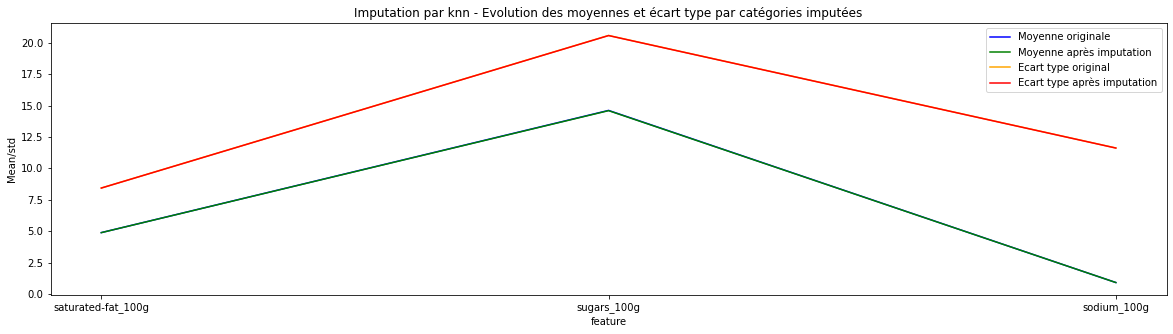

In [143]:
to_be_completed = percent_of_nans[(percent_of_nans < 25) & (percent_of_nans > 0)]
to_be_completed_high_density = to_be_completed.filter(like='_100g')
imputation(data,to_be_completed_high_density,'knn')

<b  style="background-color:tomato;font-size:12px;">&nbsp;&nbsp;&nbsp;&nbsp;7.2. MID DENSITY FEATURES<b>
    <a id="load"></a>  

In [ ]:
to_be_completed = percent_of_nans[(percent_of_nans < 50) & (percent_of_nans >= 25 )]
to_be_completed_average_density = to_be_completed.filter(like='_100g')
imputation(data,to_be_completed_average_density,'mean')

              feature  original_mean  original_std   new_mean    new_std
0  saturated-fat_100g       4.879272      8.431585   3.879272   2.431585
1         sugars_100g      14.598997     20.580312  12.598997  10.580312
2         sodium_100g       0.904823     11.618528   0.404823   6.618528


<Figure size 1440x360 with 0 Axes>

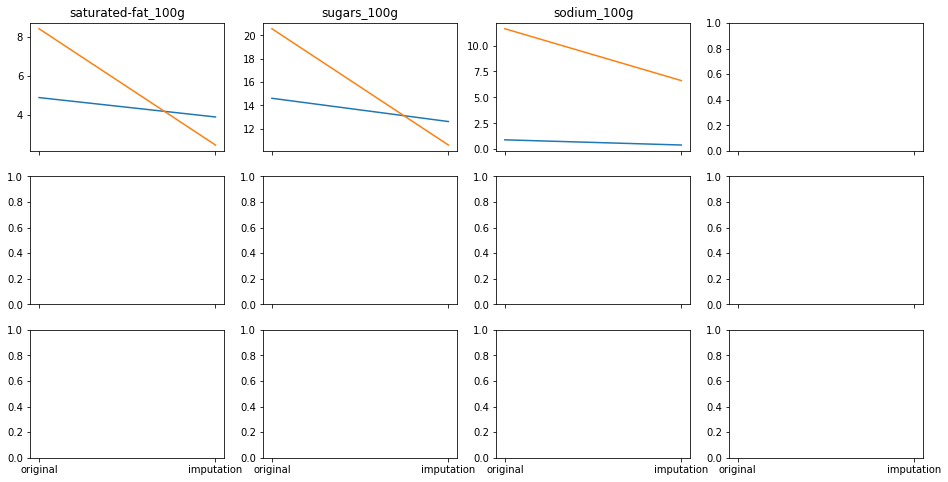

'\ni=0\nfor ax in axes.reshape(-1):\n    sns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_mean\'][i],mean_dict[\'new_mean\'][i]])\n    sns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_std\'][i],mean_dict[\'new_std\'][i]])\n    i=i+1\n\nsns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_mean\'][0],mean_dict[\'new_mean\'][0]])\nsns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_std\'][0],mean_dict[\'new_std\'][0]])\n#axes[0].set_title(mean_dict[\'feature\'][0])\n\nsns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_mean\'][1],mean_dict[\'new_mean\'][1]])\nsns.lineplot( x=[\'original\',\'imputation\'], y=[mean_dict[\'original_std\'][1],mean_dict[\'new_std\'][1]])\naxes[1].set_title(mean_dict[\'feature\'][1])\n\n\nsns.lineplot(ax=axes[1], x=sugars.index, y=sugars.values)\naxes[1].set_title(mean_dict[\'feature\'][1])\nsns.lineplot(ax=axes[2], x=sodium.index, y=sodium.values)\naxes[2].set_t

In [178]:
mean_dict = {'feature': ['saturated-fat_100g', 'sugars_100g', 'sodium_100g'], 
               'original_mean': [4.879271548407266, 14.598996855139022, 0.9048227394409329], 
               'original_std': [8.431585286234403, 20.58031162590478, 11.618527866948243], 
               'new_mean': [3.879271548407266, 12.598996855139022, 0.4048227394409329], 
               'new_std': [2.431585286234403, 10.58031162590478, 6.618527866948243]}
mean_updates=pd.DataFrame.from_dict(mean_dict)
print(mean_updates)
type="knn"
plt.figure(figsize=(20,5))


fig, axes = plt.subplots(3, 4, sharex=True, figsize=(16,8))
axes = np.array(axes)
#fig, axes = plt.subplots(3, 4, figsize=(16,8))



for i, ax in zip(range(3), axes.flat):
    #sns.distplot(data[i,0,0,0], hist=False, ax=ax)
    sns.lineplot(ax=ax, x=['original','imputation'], y=[mean_dict['original_mean'][i],mean_dict['new_mean'][i]])
    sns.lineplot(ax=ax, x=['original','imputation'], y=[mean_dict['original_std'][i],mean_dict['new_std'][i]])
    ax.set_title(mean_dict['feature'][i])
plt.show()

"""
i=0
for ax in axes.reshape(-1):
    sns.lineplot( x=['original','imputation'], y=[mean_dict['original_mean'][i],mean_dict['new_mean'][i]])
    sns.lineplot( x=['original','imputation'], y=[mean_dict['original_std'][i],mean_dict['new_std'][i]])
    i=i+1

sns.lineplot( x=['original','imputation'], y=[mean_dict['original_mean'][0],mean_dict['new_mean'][0]])
sns.lineplot( x=['original','imputation'], y=[mean_dict['original_std'][0],mean_dict['new_std'][0]])
#axes[0].set_title(mean_dict['feature'][0])

sns.lineplot( x=['original','imputation'], y=[mean_dict['original_mean'][1],mean_dict['new_mean'][1]])
sns.lineplot( x=['original','imputation'], y=[mean_dict['original_std'][1],mean_dict['new_std'][1]])
axes[1].set_title(mean_dict['feature'][1])


sns.lineplot(ax=axes[1], x=sugars.index, y=sugars.values)
axes[1].set_title(mean_dict['feature'][1])
sns.lineplot(ax=axes[2], x=sodium.index, y=sodium.values)
axes[2].set_title(mean_dict['feature'][2])


#means = sns.barplot(data=mean_updates)
sns.lineplot(data=mean_updates, x="feature", y="original_mean",color="blue", label="Moyenne originale")
sns.lineplot(data=mean_updates, x="feature", y="new_mean",color="green", label="Moyenne après imputation")
sns.lineplot(data=mean_updates, x="feature", y="original_std",color="orange", label="Ecart type original")
sns.lineplot(data=mean_updates, x="feature", y="new_std",color="red", label="Ecart type après imputation")


plt.title("Imputation par " + type + " - Evolution des moyennes et écart type par catégories imputées")
plt.ylabel("Mean/std")
"""